In [70]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('../names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1  for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i, in stoi.items()}


In [71]:
# build the dataset

block_size = 3 # context length; how many characters to look at to predict the next one
X, Y = [], []

for w in words:
    start = stoi['.']
    context = [start] * block_size
    for ch in w + '.':
        xi = stoi[ch]
        X.append(context)
        Y.append(xi)
        # print(''.join(itos[i] for i in context), '--->', itos[xi])
        context = context[1:] + [stoi[ch]]
       
    
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [72]:
C = torch.rand(27, 2)

In [73]:
out_first = F.one_hot(torch.tensor(5), num_classes=27).float() @ C
out_first

tensor([0.8016, 0.3608])

In [74]:
emb = C[X] # shape: (batch_size, block_size, emb_dim) basically 32 samples, each with 3 characters, each character has 2 dimensions

In [75]:
w1 = torch.rand(6, 100)

In [76]:
# take 32 embedings of the first character, second character, third character and flat those characters array into a single tensor
concatenatedCharacters = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) 
# alternatively, we could use 
concatenatedCharacters = torch.cat(torch.unbind(emb, 1), 1) 
# alternatively, we could use view
concatenatedCharacters = emb.view(32, 6)

RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [ ]:
W1 = torch.rand(6, 100)
b1 = torch.rand(100)
h = torch.tanh( emb.view(-1, 6) @ W1 + b1) # -1 means "infer this dimension" so the number of elelments=32x3*2 maintains the same 

In [ ]:
W2 = torch.rand(100, 27)
b2 = torch.rand(27)

logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(-1, keepdim=True)


In [ ]:
probs[torch.arange(32), Y]      # get the probability of the correct character for each of the 32 samples

loss = - probs[torch.arange(32), Y].log().mean()
print(loss)
# same as 
loss = F.cross_entropy(logits, Y)
print(loss)

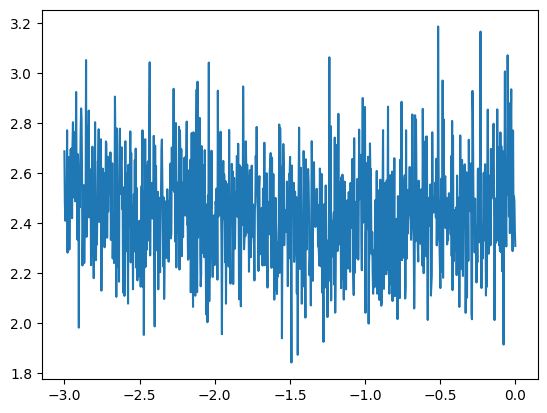

In [ ]:
parameters = [C, W1, b1, W2, b2]

lri = []
lossi = []

for p in parameters:
  p.requires_grad_()

steps = 1000
lre = torch.linspace(-3, 0, steps)
lrs = 10**lre

for i in range(steps):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  # forward pass
  emb = C[X[ix]] # shape: (batch_size, block_size, emb_dim) basically 32 samples, each with 3 characters, each character has 2 dimensions
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  # print(loss.item())

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()
  # update the weights
  # lr = lrs[i]
  lr = 0.1
  for p in parameters:
      p.data.sub_(lr * p.grad.data)
      
  # track the loss
  # lri.append(lre[i])
  # lossi.append(loss.item())
  
  
# plt.plot(lri, lossi)

In [ ]:
# training split, validation split, test split
# 80% 10% 10%